In [2]:
"""Import statements as required"""
import numpy as np
import pandas as pd
import seaborn as sbn
import matplotlib.pyplot as plt

from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

In [3]:
"""Read in data"""
results  = pd.read_csv("../Data/results.csv")
results.head()

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral
0,1872-11-30,Scotland,England,0,0,Friendly,Glasgow,Scotland,False
1,1873-03-08,England,Scotland,4,2,Friendly,London,England,False
2,1874-03-07,Scotland,England,2,1,Friendly,Glasgow,Scotland,False
3,1875-03-06,England,Scotland,2,2,Friendly,London,England,False
4,1876-03-04,Scotland,England,3,0,Friendly,Glasgow,Scotland,False


In [4]:
"""Calculate pertinent data-points"""
results["draw"] = (results["home_score"] == results["away_score"]).astype("int")
results["home_victory"] = (results["home_score"] > results["away_score"]).astype("int")

results.head()

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral,draw,home_victory
0,1872-11-30,Scotland,England,0,0,Friendly,Glasgow,Scotland,False,1,0
1,1873-03-08,England,Scotland,4,2,Friendly,London,England,False,0,1
2,1874-03-07,Scotland,England,2,1,Friendly,Glasgow,Scotland,False,0,1
3,1875-03-06,England,Scotland,2,2,Friendly,London,England,False,1,0
4,1876-03-04,Scotland,England,3,0,Friendly,Glasgow,Scotland,False,0,1


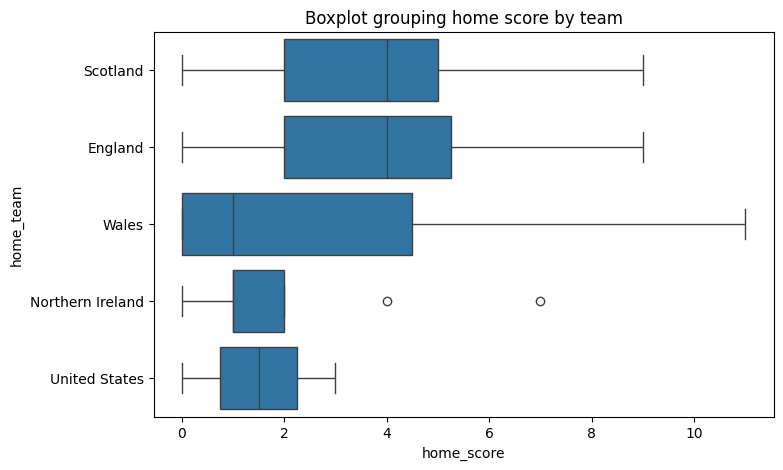

In [12]:
"""Boxplots showing points won by team"""
fig, ax0 = plt.subplots(1,1, figsize=[8, 5])
sbn.boxplot(data=results.head(n=100), x="home_score", y="home_team", orient="h").set(title="Boxplot grouping home score by team")
plt.show()

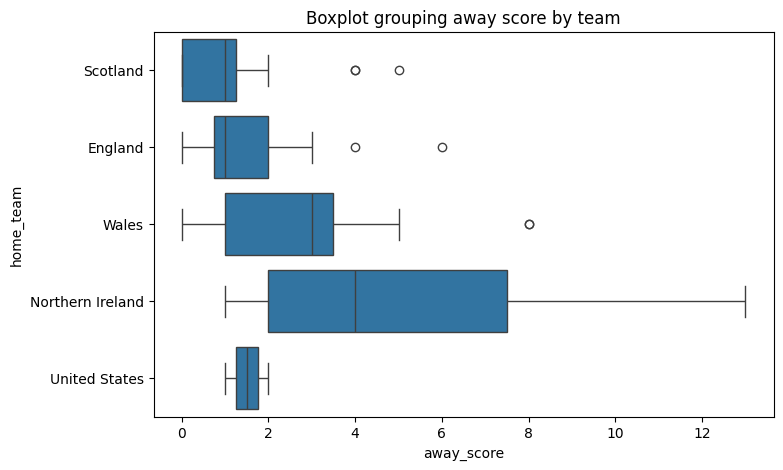

In [13]:
"""Boxplot of points lost by team"""
fig, ax0 = plt.subplots(1,1, figsize=[8,5])
sbn.boxplot(data=results.head(n=100), x="away_score", y="home_team", orient="h").set(title="Boxplot grouping away score by team")
plt.show()

In [6]:
"""Gather cummulative statistics by team"""
team_names = results["home_team"].unique()

team_stats = pd.DataFrame(columns=["team", "win", "draw", "loss", "points_won", "points_lost"])

for team in team_names:
    df = results.loc[results["home_team"] == team]
    total_wins = np.sum(df["home_victory"])
    total_draws = np.sum(df["draw"])
    total_points_won = np.sum(df["home_score"])
    total_points_lost = np.sum(df["away_score"])
    total_losses = len(df) - total_wins - total_draws

    team_stats.loc[len(team_stats)] = [team, total_wins, total_draws, total_losses, total_points_won, total_points_lost]

team_stats.head()


,team,win,draw,loss,points_won,points_lost
0,Scotland,228,88,92,774,408
1,England,335,118,87,1236,474
2,Wales,137,90,125,508,475
3,Northern Ireland,113,73,147,423,546
4,United States,261,103,113,843,481


In [7]:
"""Check to ensure there are no missing values"""
nulls = pd.DataFrame(team_stats.isnull().sum(), columns=["columns_with_null_values"])
nulls = nulls[nulls["columns_with_null_values"] > 0]
assert len(nulls) == 0
print("no null values in dataset")

no null values in dataset


In [8]:
"""Five-number summary for each column in dataset"""
team_stats.describe()

,win,draw,loss,points_won,points_lost
count,326.000000,326.000000,326.000000,326.000000,326.000000
mean,72.131902,33.484663,41.561350,258.840491,174.021472
std,85.265402,34.927856,38.256313,301.126754,159.348760
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,5.000000,2.000000,5.000000,23.000000,30.500000
50%,37.500000,21.000000,36.500000,146.000000,148.000000
75%,109.750000,60.750000,60.000000,400.500000,262.000000
max,431.000000,132.000000,177.000000,1489.000000,662.000000


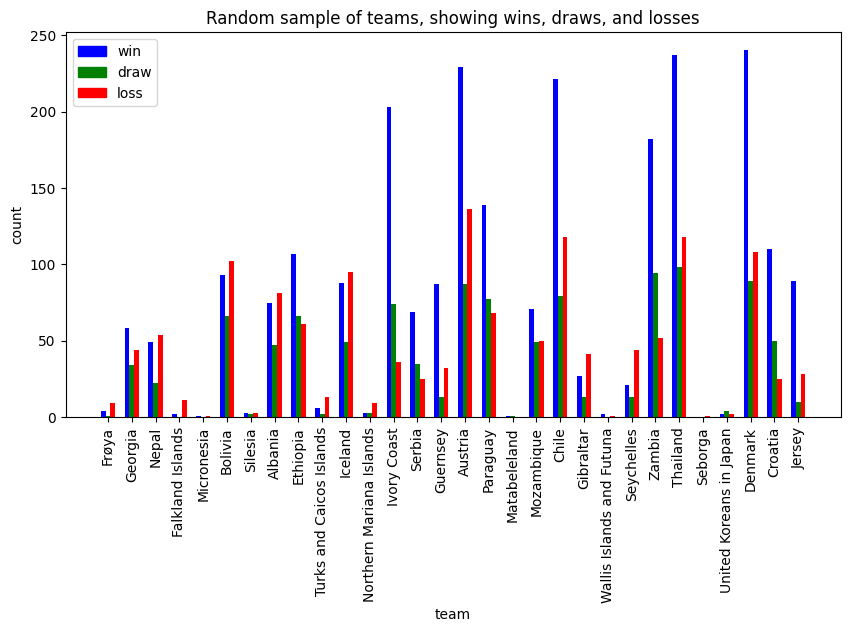

In [9]:
"""Bar graph showing wins, draws, and losses by team"""
sample = team_stats.sample(n=30, random_state=72)
sample.reset_index(drop=True, inplace=True)

fix, ax = plt.subplots(1, 1, figsize=[10, 5])
ax.bar(sample.index - 0.2, sample["win"], width=0.2, color="b", align="center")
ax.bar(sample.index, sample["draw"], width=0.2, color="g", align="center")
ax.bar(sample.index + 0.2, sample["loss"], width=0.2, color="r", align="center")
ax.set_xticks([i for i in range(30)], labels=sample["team"])

legend = {"win":"blue", "draw":"green", "loss":"red"}
legend_plot = [plt.Rectangle((0,0),1,1, color=value) for value in legend.values()]
plt.legend(legend_plot, legend.keys(), loc="upper left")

plt.title("Random sample of teams, showing wins, draws, and losses")
plt.ylabel("count")
plt.xlabel("team")
plt.xticks(rotation=90)
plt.show()

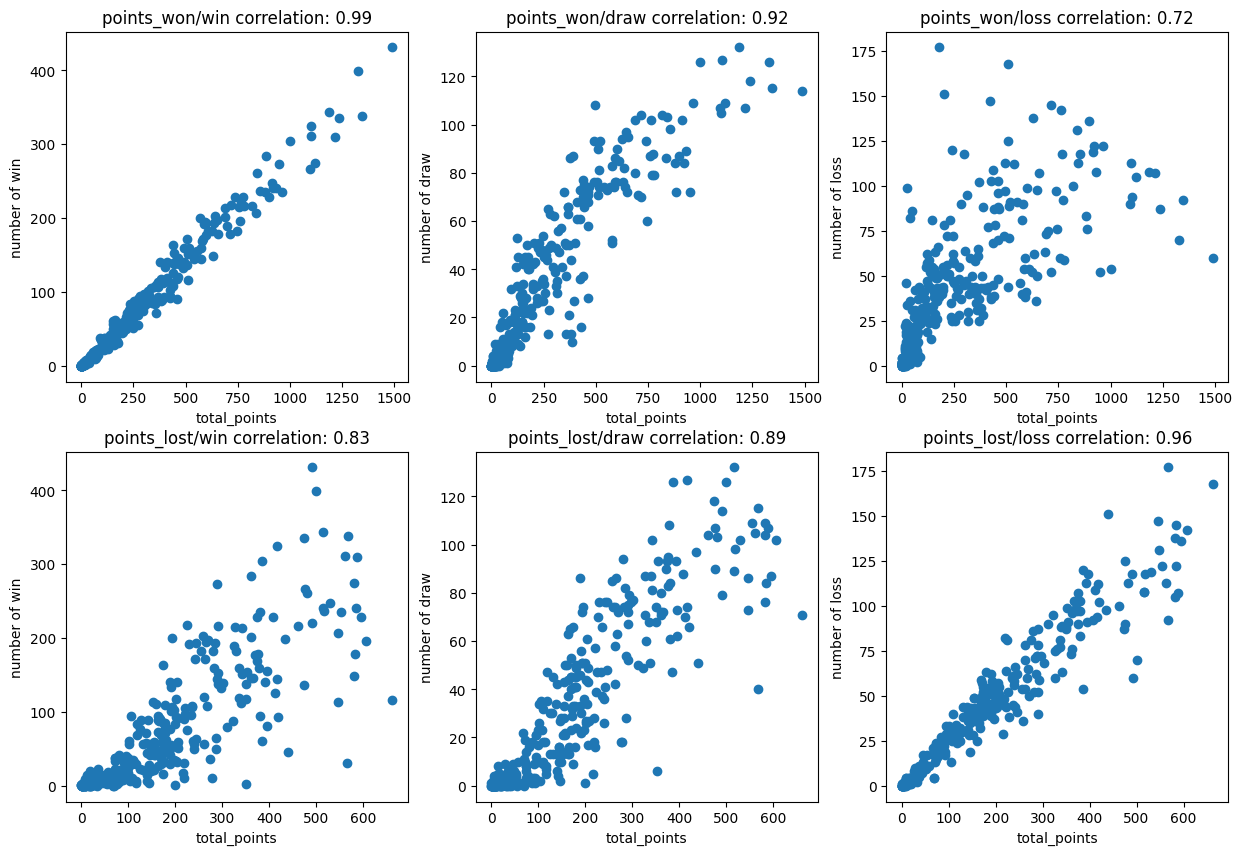

In [10]:
"""Correlation scatter plot and calculations"""
fig, axes = plt.subplots(2, 3, figsize=[15, 10])

for row_index, row in enumerate(axes):
    for ax_index, ax in enumerate(row):
        x_value = ["points_won", "points_lost"][row_index]
        y_value = ["win", "draw", "loss"][ax_index]
        title = f"{x_value}/{y_value} correlation: {round(np.corrcoef(team_stats[x_value], team_stats[y_value])[0,1], 2)}"
        ax.set(title=title, xlabel="total_points", ylabel=f"number of {y_value}")
        ax.scatter(team_stats[x_value], team_stats[y_value])

In [11]:
"""Create training data with hold out data to validate against and measure prediction accuracy"""
response_variable = team_stats[["win"]]
explanatory_variables = team_stats.loc[:, team_stats.columns != "win"]
explanatory_variables = explanatory_variables.drop(columns=["team"])

explanatory_variables, validation_explanatory, response_variable, validation_response = \
    train_test_split(explanatory_variables, response_variable, test_size=0.3, random_state=73)

print(len(response_variable), "records for training")
print(len(validation_response), "records for testing")

228 records for training
98 records for testing


In [12]:
"""Fit Linear Regression model to training data"""
model = LinearRegression()
model.fit(explanatory_variables, response_variable)

coefficients = pd.DataFrame(model.coef_.T, columns=["coefficient"])
variables = pd.DataFrame(explanatory_variables.columns, columns=["variable"])
coefficient_summary = pd.concat([variables["variable"], coefficients["coefficient"]], axis=1)
print("Intercept:", model.intercept_)
print(coefficient_summary)

Intercept: [0.04180118]
      variable  coefficient
0         draw     0.577914
1         loss     0.010452
2   points_won     0.255512
3  points_lost    -0.080836


In [13]:
"""Make predictions using hold out data"""
predictions = pd.DataFrame(model.predict(validation_explanatory), columns=["predictions"])
predictions["correct"] = validation_response.reset_index()["win"]
predictions.head()

,predictions,correct
0,2.245668,2
1,34.181534,37
2,179.874828,195
3,59.842301,58
4,124.615737,140


In [14]:
"""Calculate error rates"""
validation = mean_absolute_error(predictions["predictions"], validation_response)
print("Validation Mean Absolute Error before tuning:", round(validation, 2))

Validation Mean Absolute Error before tuning: 7.59


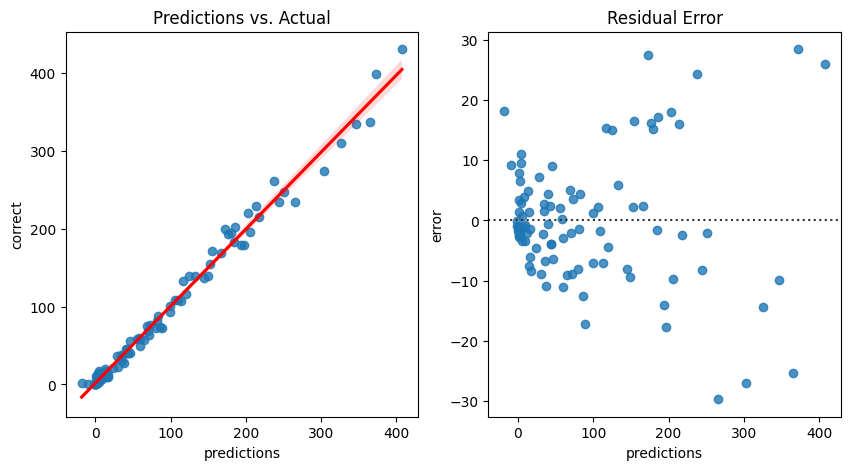

In [41]:
"""Vizualize prediction accuracy"""
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=[10, 5])

sbn.regplot(data=predictions, x="predictions", y="correct", line_kws=dict(color="r"), ax=ax0)
sbn.residplot(data=predictions, x="predictions", y="correct", ax=ax1)

ax0.set(title='Predictions vs. Actual')
ax1.set(title="Residual Error", ylabel="error")

plt.show()